#### Face Identity Classification
This example illustrates Model Inversion (MINV) attacks on a face identity classfier model. The classfier is trained on [Large-scale CelebA - Aligned&Cropped](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. Please ensure the following structure in the data folder:

directory_structure:

```
data/
    ├── private/          # Private dataset
    │   ├── identity_1/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   ├── identity_2/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   └── ...
    └── public/           # Public dataset
        ├── identity_1/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        ├── identity_2/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        └── ...      
```


To prepare data for this example:

1. Download CelebA images "img_align_celeba.zip" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ) 
2. Download CelebA identities "identity_CelebA.txt" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pOC0wOVZlQnFfaGs?resourcekey=0-pEjrQoTrlbjZJO2UL8K_WQ)
3. Unzip "img_align_celeba.zip" and place /img_align_celeba folder in examples/minv/celebA/data/
4. Place "identity_CelebA.txt" in examples/minv/celebA/data/
5. In the cell below select n classes to use, and n_private classes as private, n - n_private will be public.
6. Run the cell below

After running this, img_align_celebA folder can be removed if desired.

In [1]:
# Description: This script partitions the CelebA dataset into public and private folders based on the identity of the person in the image.

import pandas as pd
import os
import shutil

# read img_align_celeba/identity_CelebA.txt
df = pd.read_csv('./data/identity_CelebA.txt', sep=' ', header=None)
df.columns = ['img', 'label']

# Parameters
n = 1000 # total number of classes to take, max 10177
n_private = 500 # number of classes to be private, max 10177 and <= n. The rest will be public

# Create folders
os.makedirs('./data', exist_ok=True)
os.makedirs('./data/private', exist_ok=True)
os.makedirs('./data/public', exist_ok=True)

# Copy images to folders based on label
for i in range(1,n+1):
    if i <= n_private:
        # folder name should be 0-indexed
        # so we subtract 1 from the label
        os.makedirs('./data/private/' + str(i-1), exist_ok=True)
        for img in df[df['label'] == i]['img']:          
            shutil.copy('./data/img_align_celeba/' + img, './data/private/' + str(i-1) + '/' + img)
    else:
        os.makedirs('./data/public/' + str(i-1), exist_ok=True)
        for img in df[df['label'] == i]['img']:
            shutil.copy('./data/img_align_celeba/' + img, './data/public/' + str(i-1) + '/' + img)
    if i % 100 == 0:
        print(i / n * 100, 'percent copied')

10.0 percent copied
20.0 percent copied
30.0 percent copied
40.0 percent copied
50.0 percent copied
60.0 percent copied
70.0 percent copied
80.0 percent copied
90.0 percent copied
100.0 percent copied


# Train the target model

In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [2]:
from examples.minv.celebA.utils.celebA_data import get_celebA_train_test_loader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

#print(train_config)

train_loader, test_loader = get_celebA_train_test_loader(train_config)

num_classes = train_loader.dataset.dataset.get_classes()

Save data to ./data/celebA_private_data.pkl


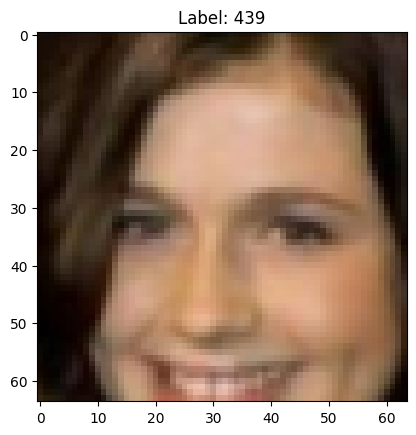

In [5]:
# plot images and labels in train_loader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# plot image and label in train_loader by index
def plot_image_and_label(train_loader, index):
    image, label = train_loader.dataset[index]
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

x = np.random.randint(0, len(train_loader.dataset)-1)
plot_image_and_label(train_loader, x)


Run this cell if you want to train the model, otherwise skip this and load it in cell below public loader

In [ ]:
from utils.resnet152_model import ResNet152
from utils.resnet152_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

import torch
# Create the model
model = ResNet152(num_classes=num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)

500


Training Progress: 100%|██████████| 30/30 [02:26<00:00,  4.88s/it]


ValidationError: 5 validation errors for OptimizerConfig
lr
  Extra inputs are not permitted [type=extra_forbidden, input_value=0.001, input_type=float]
    For further information visit https://errors.pydantic.dev/2.10/v/extra_forbidden
weight_decay
  Extra inputs are not permitted [type=extra_forbidden, input_value=0.001, input_type=float]
    For further information visit https://errors.pydantic.dev/2.10/v/extra_forbidden
momentum
  Extra inputs are not permitted [type=extra_forbidden, input_value=0.9, input_type=float]
    For further information visit https://errors.pydantic.dev/2.10/v/extra_forbidden
dampening
  Extra inputs are not permitted [type=extra_forbidden, input_value=0, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/extra_forbidden
nesterov
  Extra inputs are not permitted [type=extra_forbidden, input_value=False, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.10/v/extra_forbidden

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Public loader
from examples.minv.celebA.utils.celebA_data import get_celebA_publicloader

pub_loader = get_celebA_publicloader(train_config)


In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18

# We have model_metadata.pkl and target_model.pkl. Load metadata and target model
# Load the model
num_classes = train_loader.dataset.dataset.get_classes()
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load('./target/target_model.pkl'))
model.eval()


Remove dis.pth and gen.pth if you want LeakPro to enter training loop. Number of iterations set to n_iter = 10 in this example.

Currently, result class is not setup.

In [ ]:
from leakpro import LeakPro
from examples.minv.celebA.celebA_plgmi_handler import CelebA_InputHandler
config_path = "audit.yaml"


# Initialize the LeakPro object
leakpro = LeakPro(CelebA_InputHandler, config_path)

# Run the audit
results = leakpro.run_audit(return_results=True)


Generate some sample images

In [ ]:
from examples.minv.celebA.utils.generator import ResNetGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np

"""Generate example images using the trained generator"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# read config file
with open('audit.yaml', 'r') as file:
    config = yaml.safe_load(file)
    

dim_z = config['audit']['attack_list']['plgmi']['dim_z']

# Load generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z).to(device)
gen.load_state_dict(torch.load('gen.pth'))

# Generate images
gen.eval()

n_images = 4
z = torch.empty(n_images, dim_z, dtype=torch.float32, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device) # random labels
#y = torch.tensor([0, 1, 2, 3]).to(device) # fixed labels
print(y) 

with torch.no_grad():
    fake = gen(z, y)

# Normalize the generated images to the range [0, 1]
fake = (fake - fake.min()) / (fake.max() - fake.min())

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Printed tensor corresponds to the reconstructed identity in private dataset